# sample of multi-label CNN img classifier 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import  Input, Activation, Flatten, Conv2D, MaxPooling2D,  Dense
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt

In [ ]:
"""Use the MSTAR db as eg"""
'''after split, resize ...'''
x_train_mstar: (696, 32, 32, 1)     # 696 imgs, 32 * 32 pixels, single channel (gray scale)
x_test_mstar: (822, 32, 32, 1)
y_train_mstar: (696,)
y_test_mstar: (822,)
num_classes: 3

"""CNN define and train"""
inputs = Input(shape=(32,32,1),name="Input")
x = Conv2D(32, 3, activation="relu", padding='same',name='Conv1')(inputs)
x = MaxPooling2D(2,name='Pool1')(x)
x = Conv2D(16, 3, activation="relu",padding='same',name='Conv2')(x)
x = MaxPooling2D(2,name='Pool2')(x)
x = Flatten(name='Vectorize')(x)
x= Dense(3,name='FC')(x)
outputs= Activation("softmax",name='Softmax')(x)
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['acc'])
model.summary()

hist = model.fit(
x_train_mstar,
to_categorical(y_train_mstar, 3),  # One-hot encode your labels
batch_size=32,
epochs=10,
validation_split=0.15,
shuffle='on')   

"""test"""
y_hat=model.predict(x_test_mstar)
print('Acc=',np.sum(y_hat.argmax(1)==y_test_mstar)/y_test_mstar.shape[0])

# shap.Explainer with full image dataset



In [ ]:
import shap

def f(x):
    tmp = x.copy()
    return model(tmp)

'''
A masker is a function that takes an input image and returns a perturbed version of it in which some parts are blurred or blacked out. 
shap.Explainer uses these perturbed versions to measure how much each pixel contributes to the model prediction.
first param is the size of the blur kernel; 2nd param is the shape of the image
'''
masker_blur = shap.maskers.Image("blur(32,32)", x_test_mstar[0].shape)

'''define the shap explainer. The input is the f() (which is a wrapper of the model); the '''
explainer = shap.Explainer(f, masker_blur, output_names=list(range(3)))


ind=[600]           # means only draw the graph of the img with idx 600
shap_values_ = explainer( x_test_mstar[ind], max_evals=5000, batch_size=50 )     
shap.image_plot(shap_values_,labels=[0,1,2])

result: 

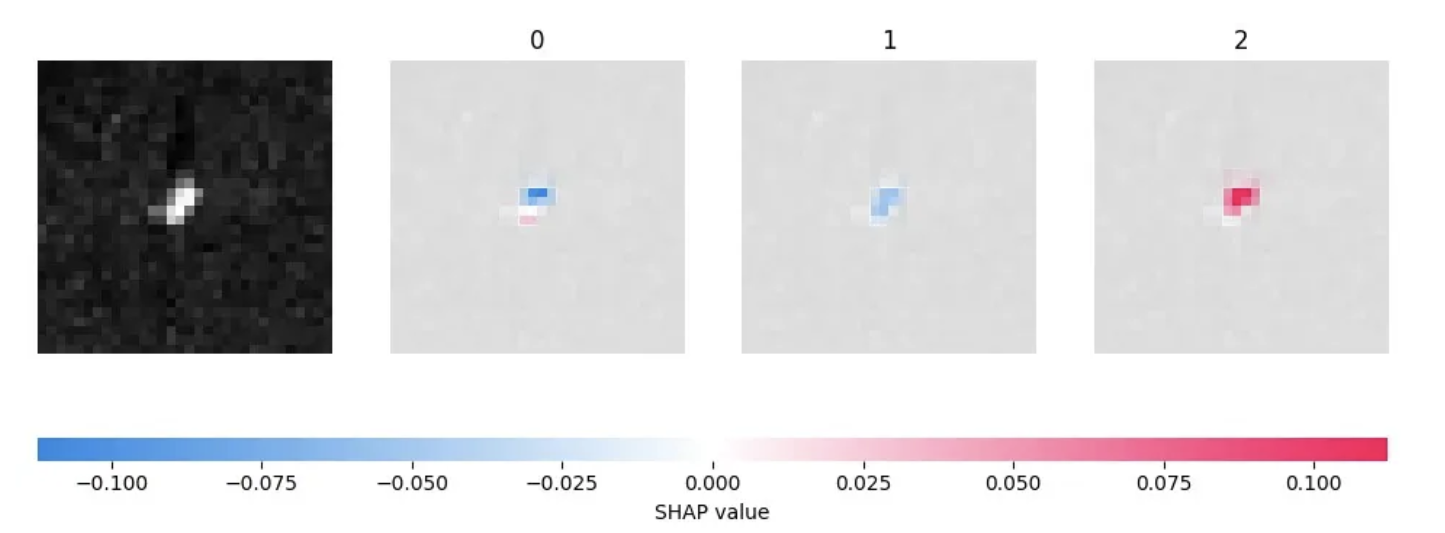

The 3 write images are the generated. Means how much the pixel contributes (or decontributes) to the final classification

# shap.DeepExplainer

Explainer: This is a basic explainer and implements estimation algorithms to explain any ML models or python function. shap.  
DeepExplainer: This explainer interprets deep learning models like LSTM by aggregating over many background sample data.

## manuals

1. `shap_values()`
   output
   

In [ ]:
"""load model and data"""
from data.model.code.cnn_only_model import CnnOnlyModel, FMEncoder
from data.model.code.test_dataset import RNAModTestDataModule
from data.model.code.utils import read_fasta
from torch.utils.data import DataLoader

'''dataset'''
test_path = Path(work_base, 'data/seq_data/fold0_test.fasta')
x_test, y_test = read_fasta(test_path, seq_len)
test_dataset = RNAModTestDataModule(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

'''model'''
model_path = Path(work_base, 'data/model/saved_model/epoch=59-val_loss=0.15.ckpt')
pretrained_CnnOnlyModel = CnnOnlyModel.load_from_checkpoint(checkpoint_path=model_path, map_location=None, seq_len=seq_len)

fmencoder = FMEncoder()

In [ ]:
"""encode data"""
batch = next(iter(test_loader))
seq_names, seqs, labels = batch
seqs = fmencoder.encode_seq(seqs)

# print(seqs.shape) # [bg_size, 128, 644]
print(seqs.device)  # cpu

In [ ]:
"""find shap value"""
seqs = seqs.to("cuda")
background = seqs[:1]
test_seqs = seqs[1:2]
# print(background.device)

e = shap.DeepExplainer(pretrained_CnnOnlyModel, background)
shap_values = e.shap_values(test_seqs, check_additivity=False)

print(shap_values.shape)        # (bg_size, 128, 644, 128)